# Bootstrap, Survival Analysis and More

## Course evaluation!!!!!

1. Bootstrap
2. Survival Analysis
    - Kaplan-Meier
    - Cox Proportional Hazards Model
3. Mixed Effects Model
4. Non-linear Effects
    - Polynomial
    - Splines

## 12.1 Bootstrap
__Why?__

Sometimes we cannot find the standard error thus the confidence interval of an estimator analytically.

We have learned from the statistics class that $\mathrm{Var}(aX+bY) = a^2\mathrm{Var}(X)+b^2\mathrm{Var}(Y)$

What about $\mathrm{Var}(XY)$ or $\mathrm{Var}(X/Y)$

__Idea__

1. Resample from our dataset with replacement for many many many times.

2. Perform the same estimation for each sample.

3. Acquire an empirical confidence interval.

__Implementation__

The __<tt>boot</tt>__ package - yours to discover. The syntax is quite simple.

### Example 1

In [1]:
n <- 10000
x <- rnorm(n, mean = 100, sd = 20)
diff(range(x))

[1] 150.4582

2.5%      50%    97.5% 
138.1897 146.7135 150.4582

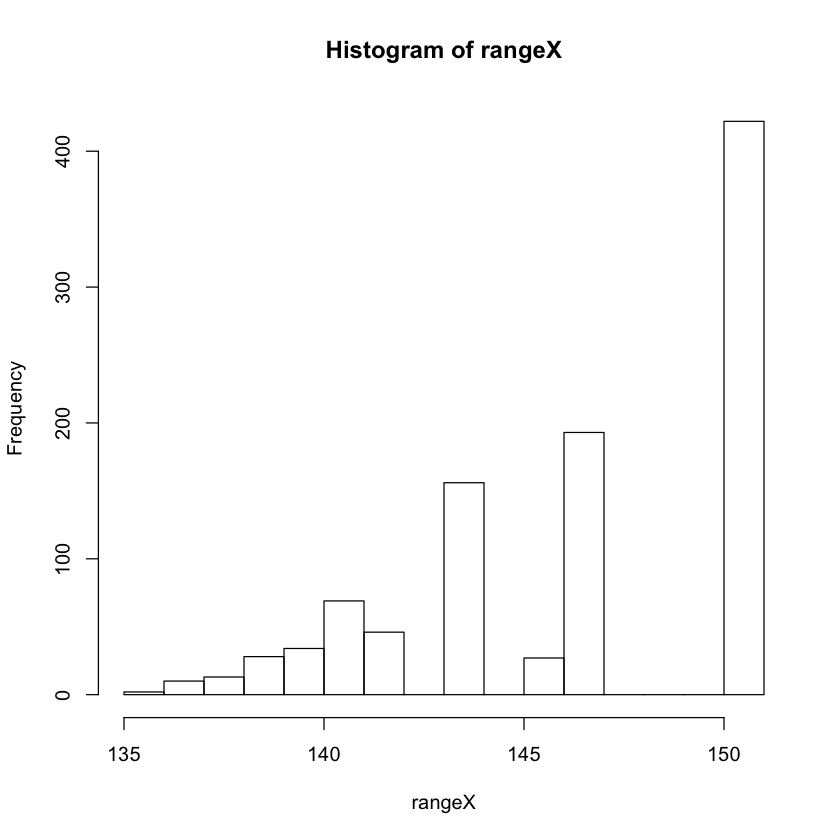

In [2]:
boot.iter <- 1000
rangeX <- numeric(boot.iter)

set.seed(613)
for (i in 1:boot.iter) {
    boot.index <- sample(1:n, n, replace = T)
    boot.sample <- x[boot.index]
    rangeX[i] <- diff(range(boot.sample))
}
quantile(x = rangeX, probs = c(0.025,0.5,0.975))
hist(rangeX, breaks = 20)

### Example 2
__An example from a bad practice.__

__Once I came across a paper that calculated the ratio of odds ratios ("ROR") of two binary variables, and claimed that the variable with bigger odds ratio (ROR$>1$) had a greater effect.__

In [3]:
# Illustration of the idea on a different dataset.
stroke <- read.csv("https://raw.githubusercontent.com/ly129/EPIB613_2019/master/stroke.csv")
head(stroke)

sex,dstr,age,coma,diab,minf,han,dead,obsmonths
<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<dbl>
Male,1991-01-02,76,No,No,Yes,No,TRUE,0.16339869
Male,1991-01-03,58,No,No,No,No,FALSE,59.60784314
Male,1991-01-08,74,No,No,Yes,Yes,TRUE,4.73856209
Female,1991-01-11,78,No,Yes,No,Yes,TRUE,0.06535948
Female,1991-01-13,76,No,Yes,No,Yes,FALSE,59.28104575
Male,1991-01-13,48,Yes,No,No,Yes,TRUE,0.10000000


In [4]:
fit <- glm(dead~sex+diab+coma+minf, data = stroke, family = binomial())
exp(coef(fit))

(Intercept)     sexMale     diabYes     comaYes     minfYes 
  1.2445152   0.5727227   1.3259460  70.2134665   2.7566108

In [5]:
# ROR of myocardial infarction vs. diabetes
ROR_minf_diab <- exp(coef(fit))[5] / exp(coef(fit))[3]
ROR_minf_diab

minfYes 
2.078977

#### This is a bad practice statistically...
1. This is simply NOT how statisticians do inference
2. There is no uncertainty (confidence interval).

In [6]:
exp(confint(fit))

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),1.0167600,1.525425
sexMale,0.4221004,0.775304
diabYes,0.8414225,2.112287
comaYes,15.4107590,1243.278155
minfYes,1.6799769,4.670801


##### Let's pretend that the analysis is OK. We still need a confidence interval for this "ROR"...
- Statistically intractable.
    - $\mathrm{Var}(\beta_{minf}/\beta_{diab})$ cannot be calculated analytically.
    
- Solution? Bootstrap!

2.5%       50%     97.5% 
0.9839096 2.1269956 4.1777443

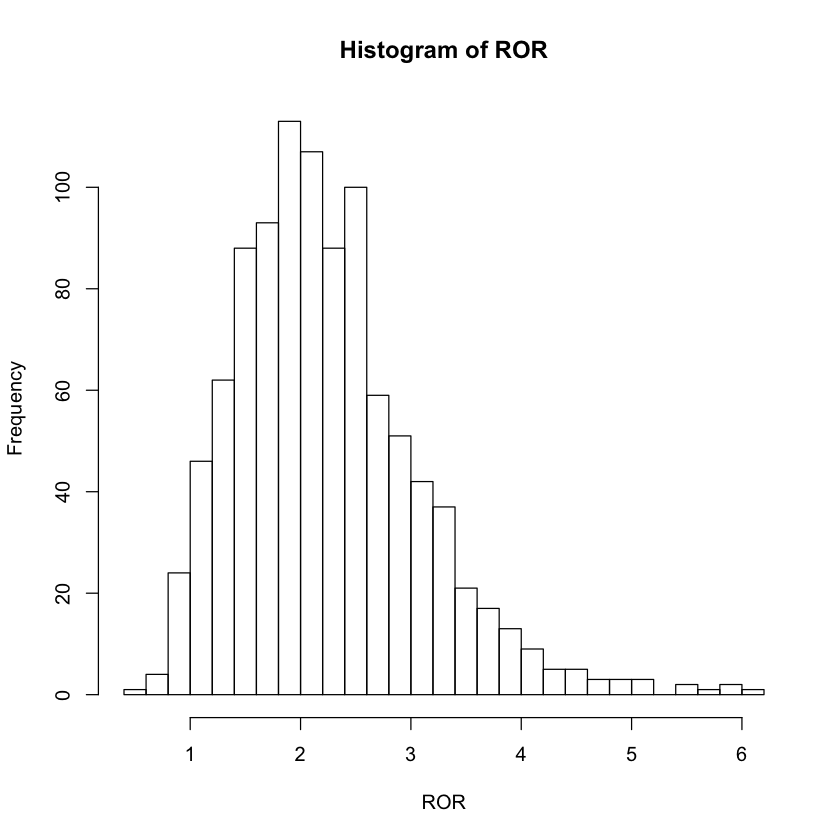

In [7]:
n <- nrow(stroke)
boot.iter <- 1000
ROR <- numeric(boot.iter)

set.seed(613)
for (i in 1:boot.iter) {
    boot.index <- sample(1:n, n, replace = T)
    boot.sample <- stroke[boot.index, ]
    fit <- glm(dead~sex+diab+coma+minf, data = boot.sample, family = binomial())
    ROR[i] <- exp(coef(fit))[5] / exp(coef(fit))[3]
}
quantile(x = ROR, probs = c(0.025,0.5,0.975))
hist(ROR, breaks = 20)

## 12.2 Survival Analysis
### 12.2.1 What is survival analysis
__Analysis of time-to-event data__

In [8]:
library(survival)
# 1=censored, 2=dead
lung <- lung[complete.cases(lung), ]
head(lung)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,3,455,2,68,1,0,90,90,1225,15
4,5,210,2,57,1,1,90,60,1150,11
6,12,1022,1,74,1,1,50,80,513,0
7,7,310,2,68,2,2,70,60,384,10
8,11,361,2,71,2,2,60,80,538,1
9,1,218,2,53,1,1,70,80,825,16


In [9]:
head(Surv(time = lung$time, event = lung$status))

[1]  455   210  1022+  310   361   218 

### 12.2.2 Kaplan-Meier Estimator
__Non-parametric maximum likelihood estimator__

_A similar estimator is called the Nelson-Aalen Estimator._

In [10]:
km <- survfit(Surv(time, status)~1, conf.int = 0.95, data = lung)
# summary(km)

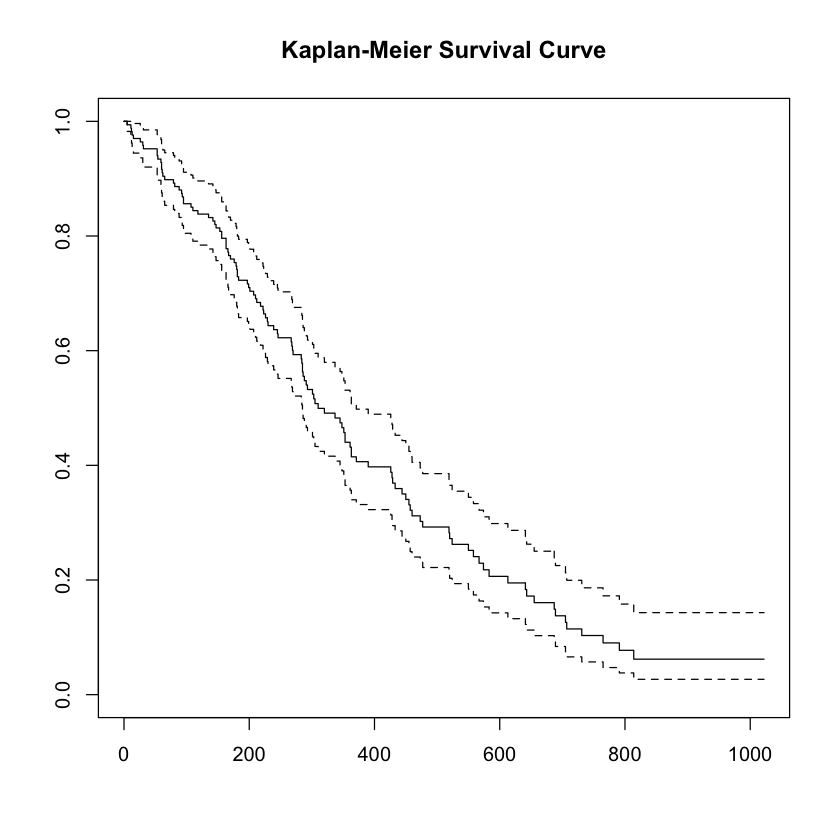

In [11]:
plot(km, conf.int = T, main = "Kaplan-Meier Survival Curve")

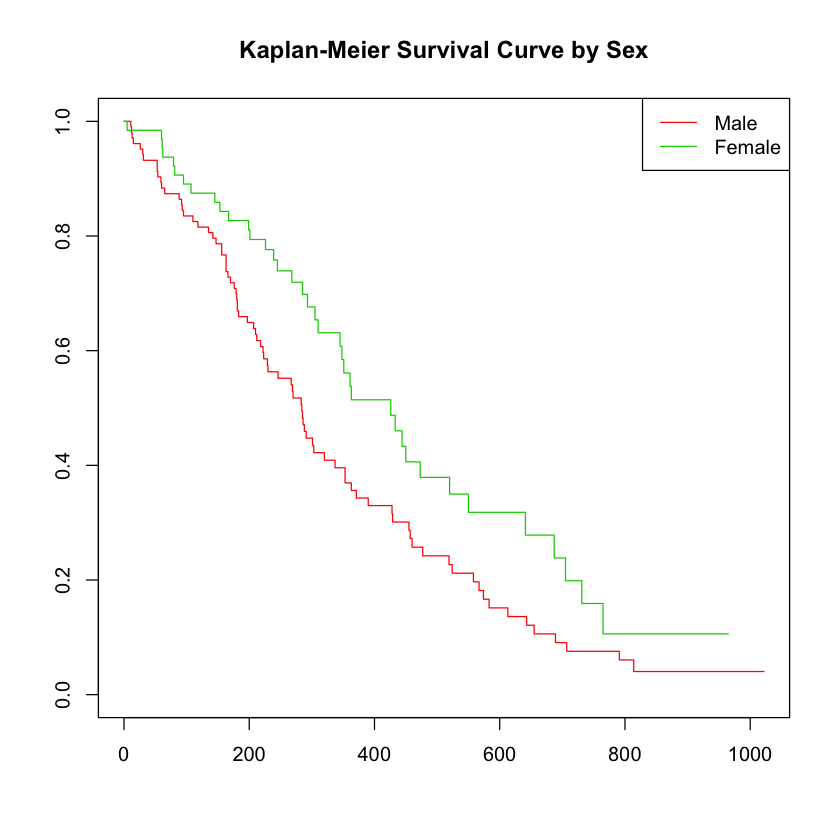

In [12]:
km.sex <- survfit(Surv(time, status)~sex, conf.int = 0.95, data = lung)
plot(km.sex, col = 2:3, main = "Kaplan-Meier Survival Curve by Sex")
legend("topright", legend=c("Male", "Female"), col=2:3, lty=c(1,1))

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1 x value <= 0 omitted from logarithmic plot”

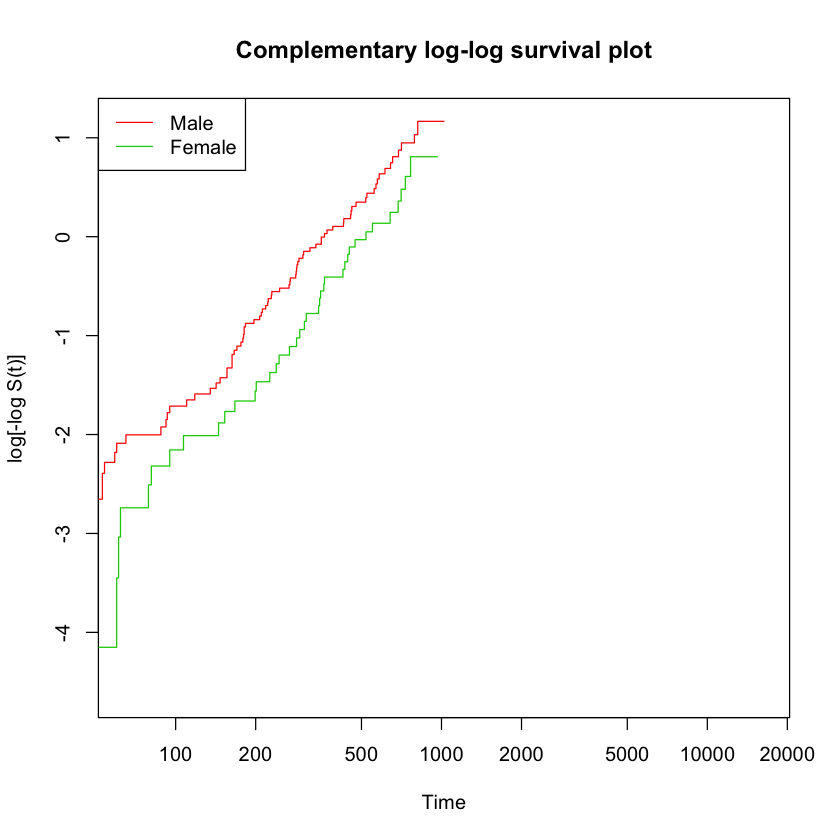

In [13]:
# Complementary log-log plot is used to check assumptions visually
# If parallel, proportional hazard assumption holds -> Cox Model (Section 12.2.3)
plot(km.sex, fun = "cloglog", col = 2:3, xlab = "Time", ylab = "log[-log S(t)]",
     main = "Complementary log-log survival plot", log = "x", xmax = 2000)
legend("topleft", legend = c("Male", "Female"), lty = c(1,1), col = 2:3)

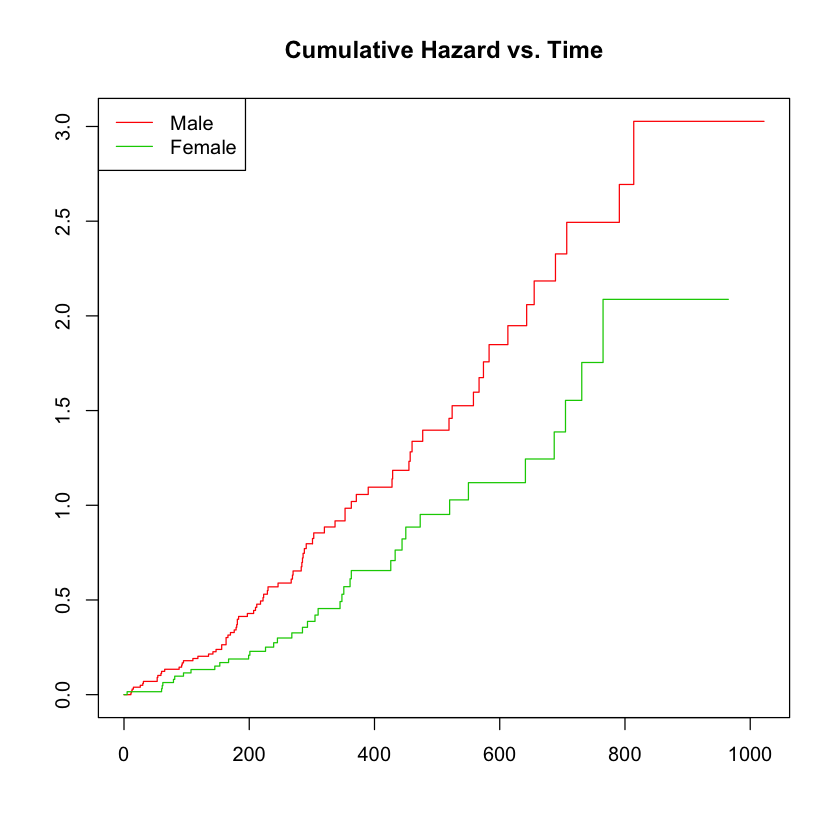

In [14]:
# Optional
# Cumulative hazard plot
plot(km.sex, fun = "cumhaz", main="Cumulative Hazard vs. Time", col = 2:3)
legend("topleft", legend = c("Male", "Female"), lty = c(1,1), col = 2:3)

#### Log-rank test
A $\chi^2$ test for inference - does sex affect survival?

In [15]:
survdiff(Surv(time, status)~sex, data = lung)

Call:
survdiff(formula = Surv(time, status) ~ sex, data = lung)

        N Observed Expected (O-E)^2/E (O-E)^2/V
sex=1 103       82     68.7      2.57      6.05
sex=2  64       38     51.3      3.44      6.05

 Chisq= 6  on 1 degrees of freedom, p= 0.01 

___How do we check the effect of multiple categorical variables? Continuous variables?___

### 12.2.3 Cox Proportional Hazards Model
__The model__
 $$ h(t) = h_0(t)\cdot\exp(\beta_1 x_1 + \beta_2 x_2+\dots) $$
__Semi-parametric__

$h_0(t)$ is an non-parametric baseline hazard
    
$h(t)$ is the actual hazard given covariates, modeled parametrically by $\boldsymbol{\beta}^\top \mathbf{x}$

__Proportional__

Under the model setup, the model assumes that $h(t)$ is proportional to $h_0(t)$ for every covariate. Why?

In [16]:
fit.cox1 <- coxph(Surv(time,status)~sex, data = lung)
summary(fit.cox1)

Call:
coxph(formula = Surv(time, status) ~ sex, data = lung)

  n= 167, number of events= 120 

       coef exp(coef) se(coef)      z Pr(>|z|)  
sex -0.4792    0.6193   0.1966 -2.437   0.0148 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

    exp(coef) exp(-coef) lower .95 upper .95
sex    0.6193      1.615    0.4212    0.9104

Concordance= 0.567  (se = 0.025 )
Likelihood ratio test= 6.25  on 1 df,   p=0.01
Wald test            = 5.94  on 1 df,   p=0.01
Score (logrank) test = 6.05  on 1 df,   p=0.01


In [17]:
# Multiple Cox regression
fit.cox2 <- coxph(Surv(time,status)~., data = lung)
summary(fit.cox2)

Call:
coxph(formula = Surv(time, status) ~ ., data = lung)

  n= 167, number of events= 120 

                coef  exp(coef)   se(coef)      z Pr(>|z|)    
inst      -3.037e-02  9.701e-01  1.312e-02 -2.315 0.020619 *  
age        1.281e-02  1.013e+00  1.194e-02  1.073 0.283403    
sex       -5.666e-01  5.674e-01  2.014e-01 -2.814 0.004890 ** 
ph.ecog    9.074e-01  2.478e+00  2.386e-01  3.803 0.000143 ***
ph.karno   2.658e-02  1.027e+00  1.163e-02  2.286 0.022231 *  
pat.karno -1.091e-02  9.891e-01  8.141e-03 -1.340 0.180160    
meal.cal   2.602e-06  1.000e+00  2.677e-04  0.010 0.992244    
wt.loss   -1.671e-02  9.834e-01  7.911e-03 -2.112 0.034647 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
inst         0.9701     1.0308    0.9455    0.9954
age          1.0129     0.9873    0.9895    1.0369
sex          0.5674     1.7623    0.3824    0.8420
ph.ecog      2.4778     0.4036    1.5523    3.9552
ph.karno     1.0

In [18]:
fit.cox3 <- coxph(Surv(time,status)~inst+sex+ph.ecog+ph.karno+wt.loss, data = lung)

In [19]:
# Model Comparison
print(anova(fit.cox1, fit.cox3))
# So here the full model has significantly better likelihood.
# Therefore, reject the reduced model.

Analysis of Deviance Table
 Cox model: response is  Surv(time, status)
 Model 1: ~ sex
 Model 2: ~ inst + sex + ph.ecog + ph.karno + wt.loss
   loglik  Chisq Df P(>|Chi|)    
1 -504.99                        
2 -492.90 24.194  4 7.302e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


___Check for proportional hazard assumption___

In [20]:
cox.zph(fit.cox3)

             rho  chisq      p
inst     -0.0831 0.9720 0.3242
sex       0.0993 1.1098 0.2921
ph.ecog   0.0263 0.0926 0.7609
ph.karno  0.1818 3.0106 0.0827
wt.loss   0.0503 0.4122 0.5208
GLOBAL        NA 7.7289 0.1718

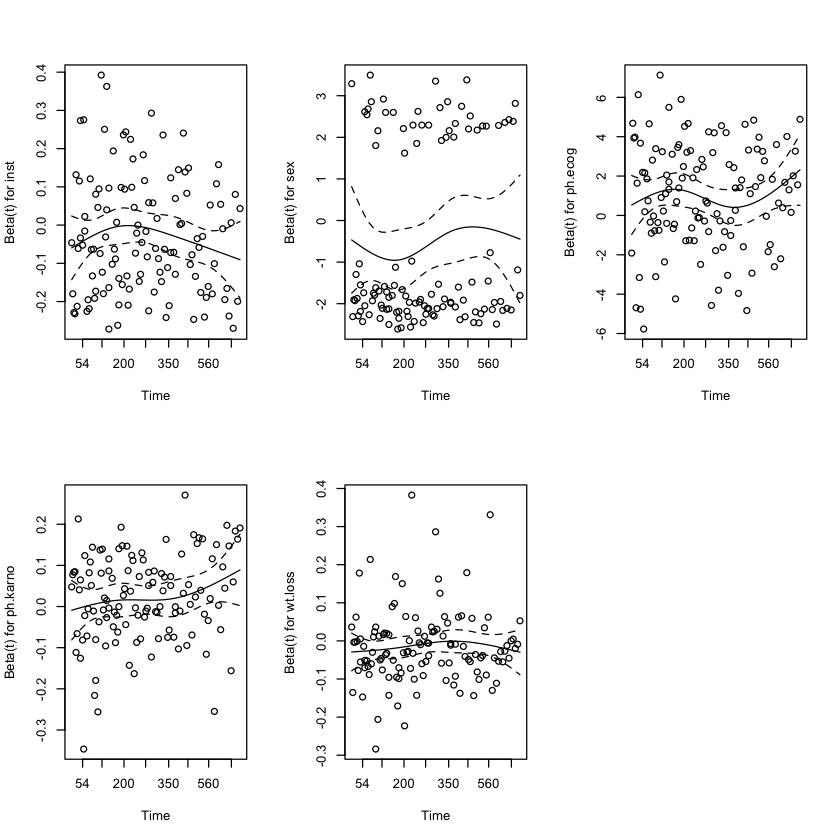

In [21]:
par(mfrow = c(2,3))
plot(cox.zph(fit.cox3))

## 12.3 Mixed Effects Model
- Mixture of fixed effects and random effects.
- Used for correlated data, such as logitudinal data

### CD4 example - the gold standard teaching data for logitudinal analysis

In [22]:
cd4 <- read.table("https://raw.githubusercontent.com/ly129/EPIB613_2019/master/cd4.txt", header = TRUE)
cd4$Date <- as.Date(cd4$Date, tryFormats = "%m/%d/%Y")
cd4$Treatment <- cd4$Treatment - 1
head(cd4, 10)

Visit,ID,Date,CD4Pct,ARV,VisAge,Treatment,BaseAge
<int>,<int>,<date>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,1988-06-29,18.0,0,3.910000,0,3.910000
4,1,1989-01-19,37.0,0,4.468333,0,3.910000
7,1,1989-04-13,13.0,0,4.698333,0,3.910000
13,1,1989-11-30,13.0,0,5.330833,0,3.910000
19,1,1990-06-07,12.0,1,5.848333,0,3.910000
1,2,1988-05-04,1.0,0,3.565000,1,3.565000
4,2,1988-07-21,0.3,0,3.778333,1,3.565000
1,3,1988-05-26,28.0,0,6.124167,0,6.124167
4,3,1988-08-18,28.0,0,6.354167,0,6.124167


In [23]:
# Total observations
dim(cd4)

[1] 1075    8

In [24]:
# Total patients
length(unique(cd4$ID))

[1] 251

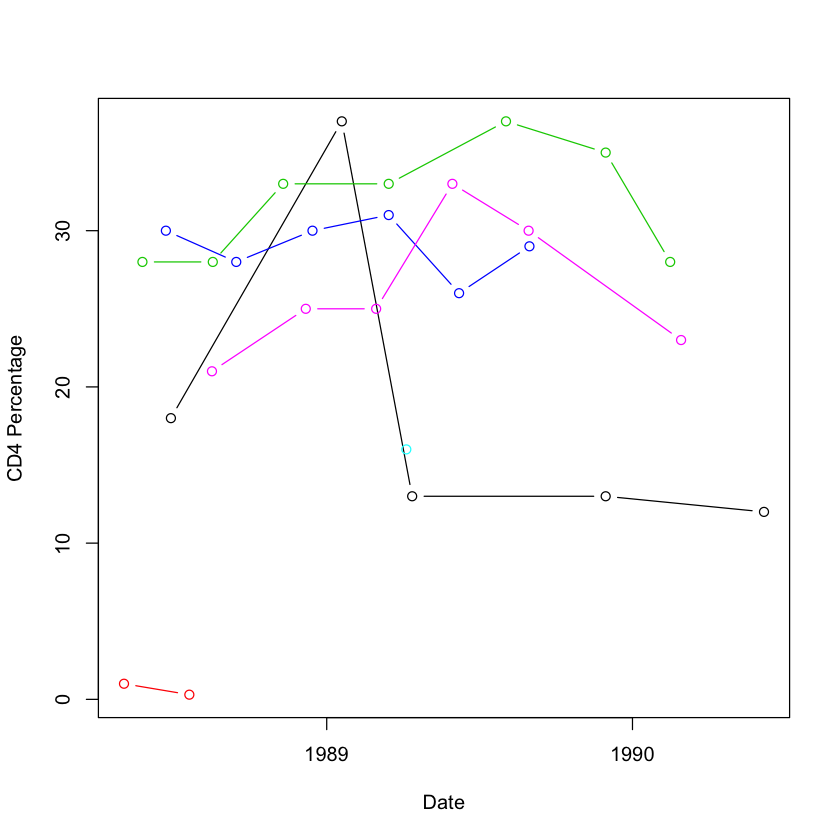

In [25]:
plot(y = cd4[cd4$ID == 1,]$CD4Pct,
     x = cd4[cd4$ID == 1,]$Date,
     type = 'b', xlab = "Date", ylab = "CD4 Percentage", col = 1,
     ylim = range(cd4$CD4Pct[1:27]),
     xlim = range(cd4$Date[1:27]))
for (i in 2:6) {
    lines(y = cd4[cd4$ID == i,]$CD4Pct,
          x = cd4[cd4$ID == i,]$Date,
          col = i, type = "b")
}

### Everyone should be allowed to have a different intercept and/or slope
Package __<tt>lme4</tt>__

In [26]:
library(lme4)

Loading required package: Matrix


In [27]:
# Random intercept model
# We can see that the syntax is exactly the same as in lm()
fit1 <- lmer(formula = CD4Pct~Date+BaseAge+Treatment+(1|ID), data = cd4)
summary(fit1)

Linear mixed model fit by REML ['lmerMod']
Formula: CD4Pct ~ Date + BaseAge + Treatment + (1 | ID)
   Data: cd4

REML criterion at convergence: 7915.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4870 -0.4510 -0.0496  0.3666  6.6900 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 131.10   11.450  
 Residual              53.42    7.309  
Number of obs: 1075, groups:  ID, 251

Fixed effects:
             Estimate Std. Error t value
(Intercept) 68.535122   9.556754   7.171
Date        -0.005890   0.001319  -4.466
BaseAge     -1.061973   0.331756  -3.201
Treatment    1.352614   1.537374   0.880

Correlation of Fixed Effects:
          (Intr) Date   BaseAg
Date      -0.986              
BaseAge   -0.130  0.009       
Treatment -0.083  0.006  0.009

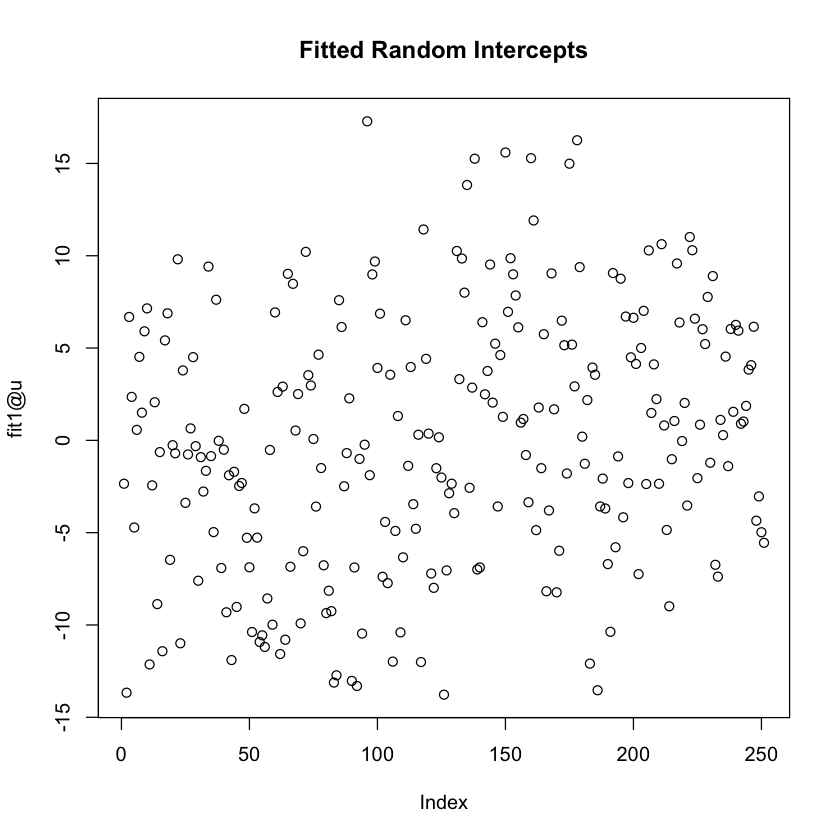

In [28]:
plot(fit1@u, main = "Fitted Random Intercepts")

In [29]:
# Random intercept + random slope for treatment
# We can see that the syntax is exactly the same as in glm()
fit2 <- lmer(formula = CD4Pct~Date+BaseAge+Treatment+(1+Treatment|ID),REML = T, data = cd4)
summary(fit2)

Linear mixed model fit by REML ['lmerMod']
Formula: CD4Pct ~ Date + BaseAge + Treatment + (1 + Treatment | ID)
   Data: cd4

REML criterion at convergence: 7914.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4934 -0.4554 -0.0521  0.3618  6.6931 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 ID       (Intercept) 138.67   11.776        
          Treatment    35.03    5.919   -0.37
 Residual              53.44    7.310        
Number of obs: 1075, groups:  ID, 251

Fixed effects:
             Estimate Std. Error t value
(Intercept) 68.287943   9.560849   7.142
Date        -0.005846   0.001319  -4.433
BaseAge     -1.080000   0.332418  -3.249
Treatment    1.362088   1.532521   0.889

Correlation of Fixed Effects:
          (Intr) Date   BaseAg
Date      -0.986              
BaseAge   -0.131  0.010       
Treatment -0.087  0.006  0.008

In [30]:
# lme4 package also has generalized linear mixed effects model
# We can see that the syntax is exactly the same as in glm()

glmer(formula = Treatment~BaseAge+ARV+(1|ID), family = binomial(), data = cd4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Treatment ~ BaseAge + ARV + (1 | ID)
   Data: cd4
      AIC       BIC    logLik  deviance  df.resid 
 387.3881  407.3084 -189.6941  379.3881      1071 
Random effects:
 Groups Name        Std.Dev.
 ID     (Intercept) 55.83   
Number of obs: 1075, groups:  ID, 251
Fixed Effects:
(Intercept)      BaseAge          ARV  
  -12.07261     -0.04340      0.03993  

In [31]:
# # Another package is nlme
library(nlme)
fit.intercept <- lme(fixed = CD4Pct~Date+BaseAge+Treatment, random = ~1|ID, data = cd4)
fit.intercept.slope <- lme(fixed = CD4Pct~Date+BaseAge+Treatment, random = ~1+Treatment|ID, data = cd4)


Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList



## 12.4 Non-linear Effects
__Effects of some variables are not linear, e.g. BMI__
### 12.4.1 Polynomial regression


Call:
lm(formula = y ~ x + x.square, data = xy)

Coefficients:
(Intercept)            x     x.square  
   -1.74201      0.05324      1.02386  


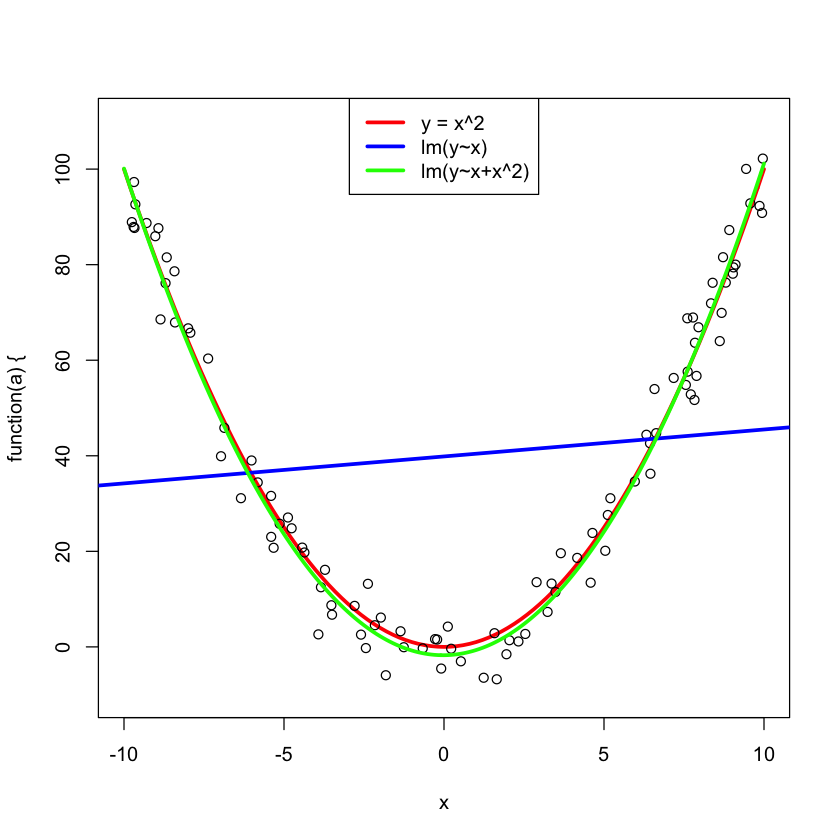

In [32]:
set.seed(613)
x <- sort(runif(100, -10,10))
y <- x^2 + rnorm(100, 0, 5)
plot(function(a){a^2}, xlim = c(-10,10), lwd = 3, col = "red", ylim = c(-10, 110))
points(x = x, y = y)

xy <- data.frame(x = x, y = y)
xy$x.square <- x^2

fit1 <- lm(y~x, data = xy); abline(fit1, col = "blue", lwd = 3)
fit2 <- lm(y~x+x.square, data = xy)
xx <- seq(-10, 10, by = 0.1)
fit2
yy <- predict(fit2, newdata = data.frame(x = xx, x.square = xx^2))
lines(x = xx, y = yy, col = "green", lwd = 3)
legend("top", legend = c("y = x^2", "lm(y~x)", "lm(y~x+x^2)"),
       lty = 1, col = c("red", "blue", "green"), lwd = c(3,3,3))

### 12.4.2 Splines
Package __<tt>splines</tt>__

Most commonly used one is cubic B-splines

Instead of modeling $y \sim x$, we model $y \sim f(x)$, where $f(x)$ is a non-linear function of x.

In [33]:
library(splines)

In [34]:
# 5 knots
head(bs(x, knots = 5))

1,2,3,4
0.00000000,0.000000e+00,0.000000e+00,0
0.01121977,3.171728e-05,2.987783e-08,0
0.01391820,4.892770e-05,5.731049e-08,0
0.01654736,6.932391e-05,9.676367e-08,0
0.02206406,1.238758e-04,2.316823e-07,0
0.08836770,2.118711e-03,1.688753e-05,0


In [35]:
fit.splines <- lm(y~bs(x, knots = 5))

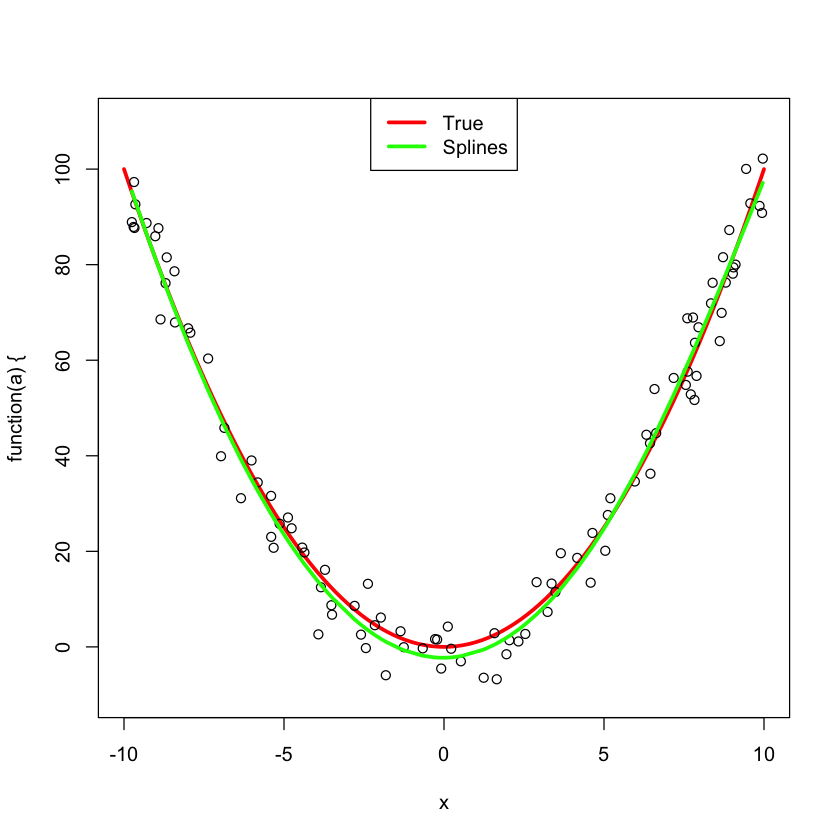

In [36]:
plot(function(a){a^2}, xlim = c(-10,10), lwd = 3, col = "red",
    ylim = c(-10, 110))
points(x = x, y = y)
lines(x, y = predict(fit.splines, newdata = bs(x, knots = 5)), col = "green", lwd = 3)
legend("top", legend = c("True", "Splines"), lwd = c(3,3), lty = c(1,1), col = c("red", "green"))